In [1]:
%matplotlib inline



# Profiles for each variable



In [2]:
from pymongo import MongoClient
from __future__ import print_function
from sklearn.externals import joblib
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.stats import norm
from sklearn.neighbors import KernelDensity


import sys
sys.path.append('../../lib')
import rs_common_framework_v4 as rs
import pysax

import pandas as pd
import datetime
import collections
import numpy as np
import math

from sklearn.decomposition import PCA, IncrementalPCA
from matplotlib import cm, pyplot as plt, style as st, gridspec as gd
from matplotlib.dates import YearLocator, MonthLocator
st.use('seaborn-colorblind')

import plotly.offline as py
import plotly.graph_objs as go  #important library for the plotly
#import cufflinks as cf
import pylab as pl
from IPython.display import display

py.init_notebook_mode(connected=False) # run at the start of every ipython notebook to use plotly.offline
from plotly import tools #to do subplots

from hmmlearn.hmm import GaussianHMM
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

print(__doc__)

Automatically created module for IPython interactive environment


In [3]:
print("\t Connected to Mongo DB")

collection_feature_selection = 'feature_selection'
collection_statistics_daily = 'statistics_daily'
seasons = ['summer', 'winter', 't_period_1', 't_period_2']
day_type = ['working_day', 'weekend', 'holiday']

# select tag name
tag_query = {'category': {'$in': ['Temperature']}, 
             'floor': {'$in': [1,2,3]}}
path_model = '../../HMM_models/Draft_models/'
file_name = 'hmm_' + collection_statistics_daily + '_'

db_name = "project_db"
connection = MongoClient('localhost')  # "192.168.6.132"
collection_metadata = connection[db_name]["metadata"]
collection_series = connection[db_name]["filtered_time_series"]
collection_statistics_general = connection[db_name]["statistics_general"]

collection_statistics_daily = connection[db_name][collection_statistics_daily]
collection_feature_selection = connection[db_name][collection_feature_selection]

	 Connected to Mongo DB


In [4]:
print('Get tag names')
tag_list = rs.get_tag_names(collection_metadata, tag_query)


Get tag names


In [5]:
tag = tag_list[0]
print('Get time series for tag :', tag)
# NOT CHANGE THIS
start_time = '2012-06-23 00:00:00' # this is fixed
end_time = '2015-06-08 23:00:00'   # this is fixed
timeline = pd.date_range(start_time, end_time, freq='1H')
strtimeline = [str(x) for x in timeline]
time_query = {'timestamp': {'$in' : strtimeline}}
df_raw = rs.get_tag_values(collection_series, time_query, tag, series_format='DF_t')
df_raw = df_raw.reindex(timeline)
df_raw[tag].fillna(df_raw[tag].interpolate(), inplace=True)
df_raw[tag].fillna(df_raw[tag].mean(), inplace=True)
df_raw.sort_index(inplace=True)

print('from {0} to {1} '.format(timeline[0], timeline[1]))
print('Number of registers: ', len(df_raw[tag].index))

Get time series for tag : V044_room101_temp
from 2012-06-23 00:00:00 to 2012-06-23 01:00:00 
Number of registers:  25944


In [6]:
def approximate_pdf(axes, X, banwidth=0.2 ,gridsize=100):
    n, bins, patches = axes.hist(X, gridsize, normed=True, facecolor='gray', alpha=0.6)
    
    dx = np.linspace( -6, 6, 10000)[:, np.newaxis]
    X = X[:, np.newaxis]

    # Gaussian KDE
    kde = KernelDensity(kernel='gaussian', bandwidth=banwidth).fit(X)
    log_dens = kde.score_samples(dx)
    pdf = np.exp(log_dens)
    l = max(abs(bins))
    axes.set_xlim([-5, 5])
    axes.plot(dx[:, 0], pdf, lw=2, color='black')
    
    return pdf, dx[:, 0], n, bins, patches

In [7]:
from matplotlib import gridspec

print('General Information and defining a timeline for a sample to see')
# small extract of the timeseries
start_sample = pd.Timestamp('2013-07-11 00:00:00')
end_sample = pd.Timestamp('2013-07-15 00:00:00')
print('Define a sample to see from {0} to {1}'.format(start_sample,end_sample))

df_t = df_raw.loc[start_sample:end_sample]
df_norm_sample = df_t.copy()

# exclude 3*sigma values:
UCL = df_raw[tag].mean() + 3*df_raw[tag].std()
LCL = df_raw[tag].mean() - 3*df_raw[tag].std()
df_std = df_raw[(df_raw[tag]>=LCL)&(df_raw[tag]<=UCL)]

# z-score normalization
general_mean = df_std[tag].mean()
general_std = df_std[tag].std()
#print(general_mean, general_std)
df_norm_sample = (df_norm_sample - general_mean ) / (general_std) #only to show a small part of the trend
df_x = (df_raw - general_mean) / (general_std)
df_std = (df_std - general_mean) / (general_std)
print('Number od registers that are inside of the 3 std:', len(df_std.index))
print('The mean of the original series is {0} and standard deviation {1}'.format(round(df_raw[tag].mean(),3), round(df_raw[tag].std(),3)))
print('The mean of the filtered series is {0} and standard deviation {1}'.format(round(general_mean,3), round(general_std,3)))
print('The mean of the normalized series is {0} and standard deviation {1}'.format(round(df_x[tag].mean(),2), df_x[tag].std()))


General Information and defining a timeline for a sample to see
Define a sample to see from 2013-07-11 00:00:00 to 2013-07-15 00:00:00
Number od registers that are inside of the 3 std: 25830
The mean of the original series is 25.138 and standard deviation 1.013
The mean of the filtered series is 25.123 and standard deviation 0.987
The mean of the normalized series is 0.02 and standard deviation 1.0260794568070506


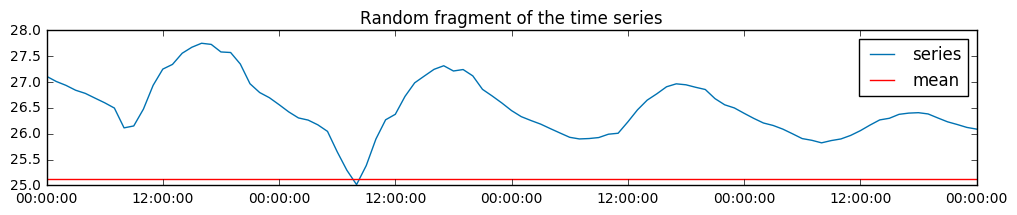

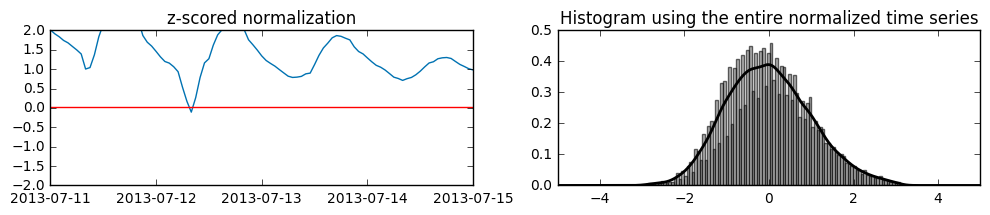

In [8]:
import matplotlib.dates as mdates
ymdhFmt = mdates.DateFormatter('%Y-%m-%d %H:%M')

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,2))
axes.plot(df_t, label='series')
axes.plot(df_t.index,[general_mean]*len(df_t.index),'r', label='mean')
axes.set_title('Random fragment of the time series')
axes.legend()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,2))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 2])
axes[0] = plt.subplot(gs[1])
axes[1] = plt.subplot(gs[0])

pdf, dx, n, bins, patches = approximate_pdf(axes[0], df_std[tag], banwidth=0.15, gridsize=100)

df_m = pd.DataFrame(index=df_norm_sample.index)
df_m['mean'] = [df_x.mean()]*len(df_norm_sample.index)
axes[0].set_title('Histogram using the entire normalized time series')
axes[1].set_ylim([-2,2])
axes[1].plot(df_norm_sample)

axes[1].plot(df_m,color='red')
axes[1].set_title('z-scored normalization')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[1].xaxis.set_major_locator(mdates.DayLocator(interval=1))

plt.show()

In [9]:
print('Define SAX model')
# number of divisions) for SAX representation
sax_nbins_size = 4              # 4 is the final value
sax_alphabet = "abcd"           # "LbaH" is the final alphabet
window = 24                     # 24 hours window, stride = window because we do not want overlapping windows
sax = pysax.SAXModel(stride=window, window=window,  nbins=sax_nbins_size, alphabet=sax_alphabet)

Define SAX model


In [10]:
gaussian_cutpoints = {3 : [ -0.43, 0.43],
4 : [ -0.67, 0, 0.67],
5 : [ -0.84, -0.25, 0.25, 0.84],
6 : [ -0.97, -0.43, 0, 0.43, 0.97],
7 : [ -1.07, -0.57, -0.18, 0.18, 0.57, 1.07],
8 : [ -1.15, -0.67, -0.32, 0, 0.32, 0.67, 1.15],
9 : [ -1.22, -0.76, -0.43, -0.14, 0.14, 0.43, 0.76, 1.22],
10: [ -1.28, -0.84, -0.52, -0.25, 0, 0.25, 0.52, 0.84, 1.28],
11: [ -1.34, -0.91, -0.6, -0.35, -0.11, 0.11, 0.35, 0.6, 0.91, 1.34],
12: [ -1.38, -0.97, -0.67, -0.43, -0.21, 0, 0.21, 0.43, 0.67, 0.97, 1.38],
13: [ -1.43, -1.02, -0.74, -0.5, -0.29, -0.1, 0.1, 0.29, 0.5, 0.74, 1.02, 1.43],
14: [ -1.47, -1.07, -0.79, -0.57, -0.37, -0.18, 0, 0.18, 0.37, 0.57, 0.79, 1.07, 1.47],
15: [ -1.5, -1.11, -0.84, -0.62, -0.43, -0.25, -0.08, 0.08, 0.25, 0.43, 0.62, 0.84, 1.11, 1.5],
16: [ -1.53, -1.15, -0.89, -0.67, -0.49, -0.32, -0.16, 0, 0.16, 0.32, 0.49, 0.67, 0.89, 1.15, 1.53],
17: [ -1.56, -1.19, -0.93, -0.72, -0.54, -0.38, -0.22, -0.07, 0.07, 0.22, 0.38, 0.54, 0.72, 0.93, 1.19, 1.56],
18: [ -1.59, -1.22, -0.97, -0.76, -0.59, -0.43, -0.28, -0.14, 0, 0.14, 0.28, 0.43, 0.59, 0.76, 0.97, 1.22, 1.59],
19: [ -1.62, -1.25, -1, -0.8, -0.63, -0.48, -0.34, -0.2, -0.07, 0.07, 0.2, 0.34, 0.48, 0.63, 0.8, 1, 1.25, 1.62],
20: [ -1.64, -1.28, -1.04, -0.84, -0.67, -0.52, -0.39, -0.25, -0.13, 0, 0.13, 0.25, 0.39, 0.52, 0.67, 0.84, 1.04, 1.28, 1.64]}

In [11]:
def obtain_cutpoints(pdf, dx, n):
    tp = simps(pdf,dx)
    to_distribute = tp/n
    print("Area under the curve: {0}, is distributed in {1} areas of {2}".format(tp, n, to_distribute) )
    
    cutpoints = list()
    y_toplt = list()
    i = 0
    for j in range(1,len(dx)):
        x = dx[i:j]
        y = pdf[i:j]
        r = simps(y,x)
        if r >= to_distribute:
            delta = r - to_distribute
            to_distribute += delta #to compensated the small area
            i=j-1
            cutpoints.append(dx[i])
            y_toplt.append(pdf[i])

    return cutpoints, y_toplt

Area under the curve: 0.9999999999993047, is distributed in 4 areas of 0.24999999999982617
Area under the curve: 0.9999999980268248, is distributed in 4 areas of 0.2499999995067062
Here the list of cutpoints for the Gaussian distribution: 
	 [-0.67, 0, 0.67]
Here the list of new proposed cutpoints for the variable: 
	 [-0.71999999999999997, -0.050000000000000003, 0.67000000000000004]


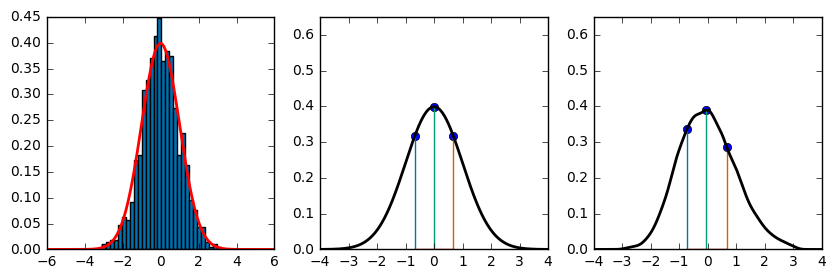

In [12]:
from scipy.integrate import simps
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,3))
gs = gridspec.GridSpec(1, 3, width_ratios=[2, 2, 2])
axes[0] = plt.subplot(gs[0])
axes[1] = plt.subplot(gs[1])

cutpoints1, y_toplt = obtain_cutpoints(pdf, dx , len(sax_alphabet))
cutpoints1 = [round(x,2) for x in cutpoints1]
axes[2].stem(cutpoints1, y_toplt, '-')
axes[2].plot(dx, pdf, lw=2, color='black')

mu, sigma = 0, 1 # mean and standard deviation
X = np.random.normal(mu, sigma, 1000)
count, bins, ignored = axes[0].hist(X, 30, normed=True)
pdf2 = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (dx - mu)**2 / (2 * sigma**2))
axes[0].plot(dx, pdf2 ,linewidth=2, color='r')

cutpoints_approx, y_toplt = obtain_cutpoints(pdf2, dx , len(sax_alphabet))
cutpoints2 = gaussian_cutpoints[len(sax_alphabet)]
axes[1].stem(cutpoints2, y_toplt, '-')
axes[1].plot(dx, pdf2, lw=2, color='black')

axes[1].set_ylim([0,0.65])
axes[2].set_ylim([0,0.65])
axes[1].set_xlim([-4,4])
axes[2].set_xlim([-4,4])
print("Here the list of cutpoints for the Gaussian distribution: \n\t", cutpoints2)
print("Here the list of new proposed cutpoints for the variable: \n\t", cutpoints1)


plt.show()

In [13]:
def y_to_plot(yvalue, sax_nbins_size, df_index):
    y_square = []
    t_square = []
    i = 0
    nbin = int(24/sax_nbins_size)
    bef = 0
    #print(nbin)
    for y in yvalue:
        for s in y:
            if i > 0:
                y_square.append([bef,s])
                t_square.append(list(df_index[i-1:i+1]))
            
            a = list([s]*(nbin))
            y_square.append(a)
            t_square.append(list(df_index[i:i+nbin]))
            
            bef = s
            i += nbin
    
    return y_square , t_square 

In [14]:
#import matplotlib.dates as mdates
def plot_sax_sequence(axes, list_word, paa_sequence, df_norm_sample, cutpoints):
    
    letters_to_plot = [item for sublist in list_word for item in sublist]
    letters_to_plot = [ [x,x] for x in letters_to_plot]
    letters_to_plot = [item for sublist in letters_to_plot for item in sublist]
    
    y_square, t_square = y_to_plot(paa_sequence, sax_nbins_size, df_norm_sample.index)
    axes.plot(df_norm_sample, label='series', lw=1)
    for y, t, w in zip(y_square,t_square, letters_to_plot):
        if len(y)>2:
            axes.plot(t,y, color='gray', lw=2)
            axes.annotate(w, xy=(t[-2], y[0]+0.15), xytext=(t[-2], y[0]+0.15), clip_on=True)
        #else:
        #    axes.plot(t,y, color='gray', lw=0.5)
    for cut in cutpoints:
        axes.plot(df_norm_sample.index, [cut]*len(df_norm_sample.index), '--', color='gray')
    
    
    axes.plot(df_norm_sample.index, [0]*len(df_norm_sample.index), '-', color='red', lw=0.3)
    axes.set_ylim([-2.2, 2.2])
    axes.set_yticks([-3,-2] + cutpoints + [2, 3])
    
    


The mean of the trend is 0.015189973847822823 and variance 1.0260794568070506
Number of days to explore: 1081


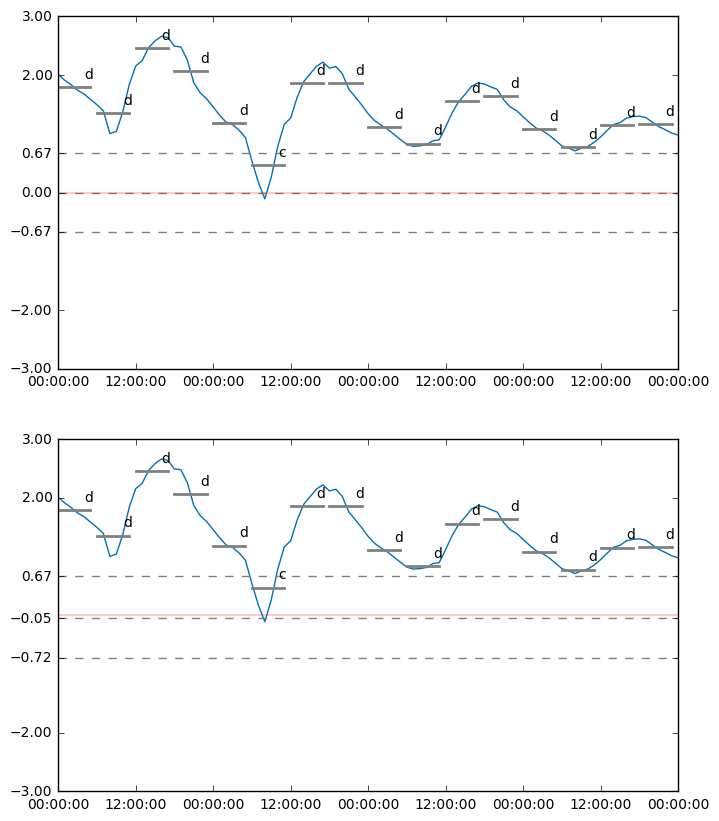

In [15]:
timeline = pd.date_range(start_time, end_time, freq='1D')
timeline_sample = pd.date_range(start_sample, end_sample, freq='1D')

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,10))
gs = gridspec.GridSpec(2, 1, width_ratios=[2, 1])
axes[0] = plt.subplot(gs[0])
axes[1] = plt.subplot(gs[1])

print('The mean of the trend is {0} and variance {1}'.format(df_x[tag].mean(), df_x[tag].std()))
# transform to SAX
words = sax.symbolize_signal(df_x[tag].values)
df_sax = pd.DataFrame(index=timeline,data=words,columns=['sax_word'])
#print(df_sax.info())
print('Number of days to explore:', len(words))

list_words = df_sax['sax_word'].loc[timeline_sample] 
paa_sequence = sax.signal_to_paa_vector(df_norm_sample[tag].values)
plot_sax_sequence(axes[0], list_words, paa_sequence, df_norm_sample, cutpoints2)


# using new sax proposition:
cutpointsaux = [-np.inf] + cutpoints1 + [np.inf]
sax2 = pysax.SAXModel(stride=window, window=window,  nbins=sax_nbins_size, alphabet=sax_alphabet, cutpoints=cutpointsaux )
# transform to SAX
words = sax2.symbolize_signal(df_x[tag].values)
df_sax2 = pd.DataFrame(index=timeline,data=words,columns=['sax_word'])
#print(df_sax.info())
list_words = df_sax2['sax_word'].loc[timeline_sample] 
paa_sequence = sax2.signal_to_paa_vector(df_norm_sample[tag].values)

plot_sax_sequence(axes[1], list_words, paa_sequence, df_norm_sample, cutpoints1)

plt.show()


	Reading the HMM model: 
../../HMM_models/Final_models/named_V044_room101_temp.pkl


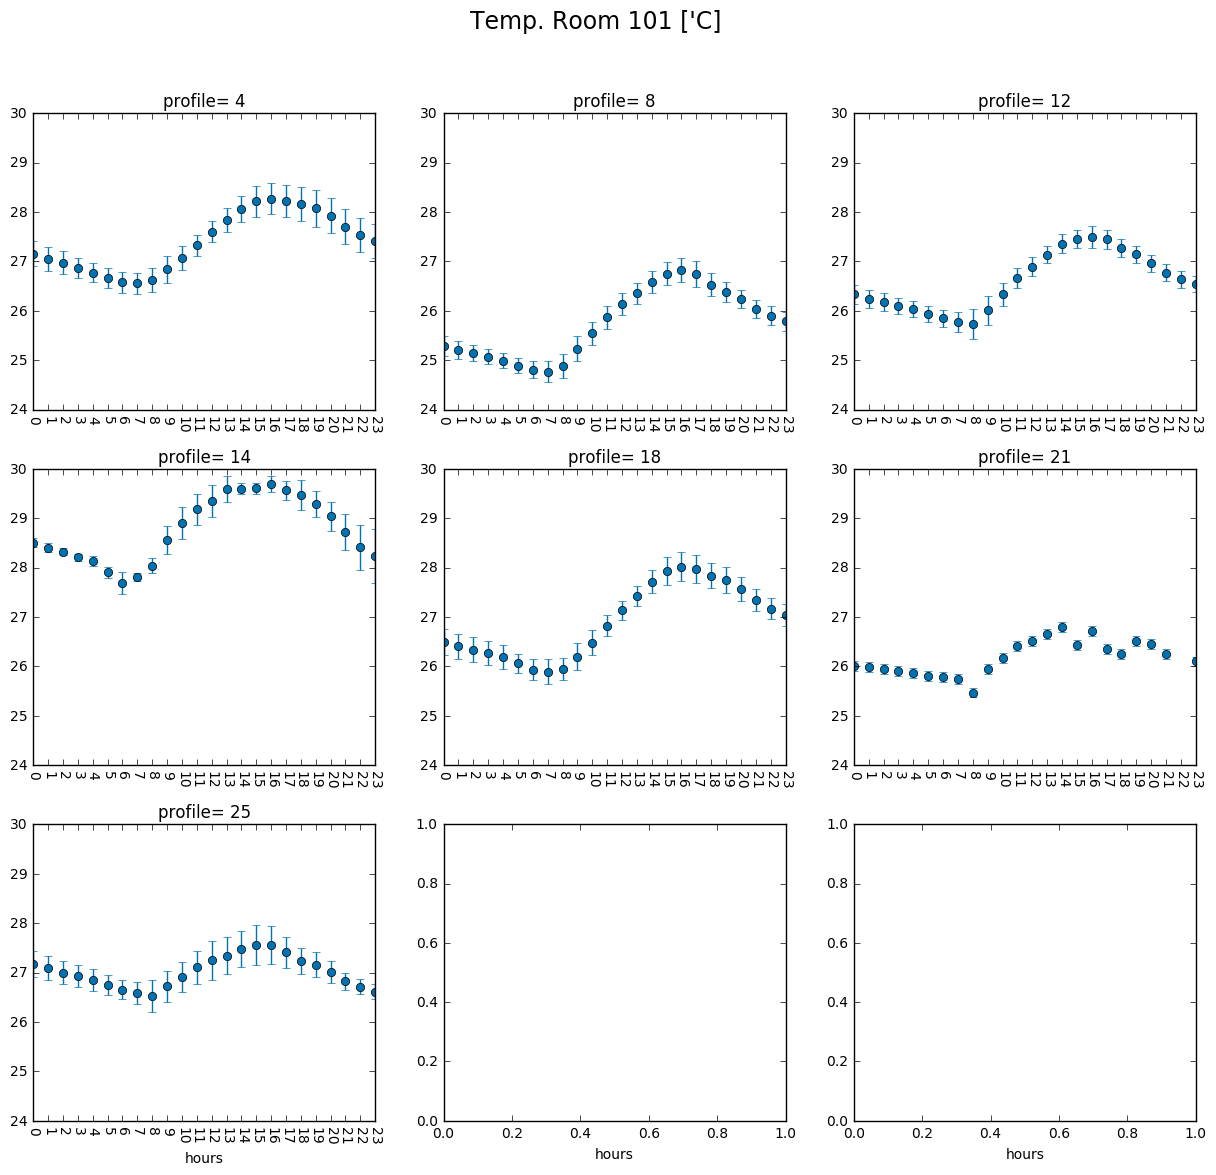

In [26]:
path_final_model = '../../HMM_models/Final_models/' + 'named_'
file_name = tag + '.pkl'
path_open = path_final_model + file_name
print("\tReading the HMM model: \n{0}".format(path_open)) 
dict_model = joblib.load(path_open)
model = dict_model['model']
n_comp = model.n_components
n_features = model.n_features
discord_candidates = dict_model['discord_candidates']
motif_candidates = dict_model['motif_candidates']

ylim = [24, 30]

nrows = int(np.ceil(len(discord_candidates)/3))
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15,13))
title = rs.get_alias(collection_metadata,tag) + \
        " [" + rs.get_field_value(collection_metadata,{'tagname': tag},'units') + "]"
fig.suptitle(title, fontsize=17)
i = 0
j = 0
x = range(24)

for n in discord_candidates:
    y = model.means_[n]
    e = (np.diag(model.covars_[n]))**(0.5)
    if j>2: 
        j=0
        i+=1
    axes[i][j].errorbar(x, y, e, linestyle='None', marker='o')
    axes[i][j].set_xticks(x)
    axes[i][j].set_xlim([0,23])
    axes[i][j].set_xticklabels(labels = x, rotation=-90)
    axes[i][j].set_ylim(ylim)
    axes[i][j].set_title('profile= ' + str(n))
    axes[-1][j].set_xlabel('hours')
    j+=1
    #print(e)
#plt.tight_layout()

the profile 21 is transformed to: ['cccb']
the profile 21 is transformed to: ['dddb']


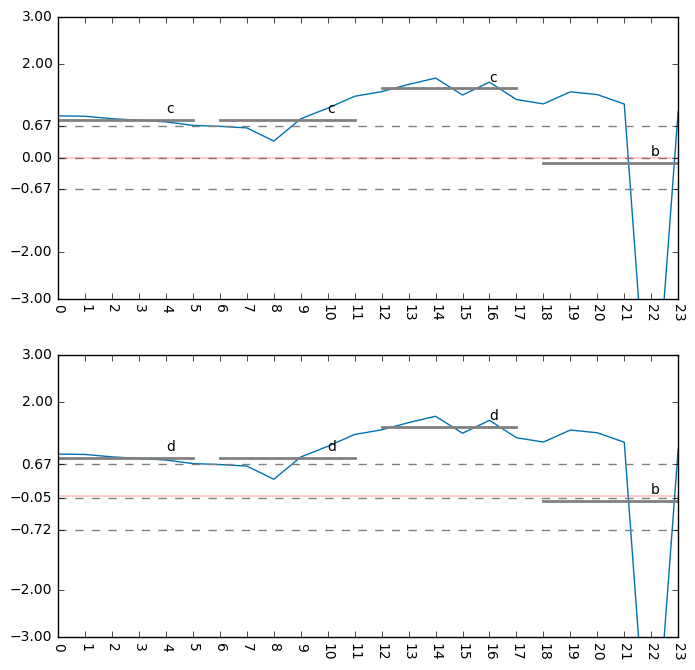

In [24]:
select_profile = 21

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12,8))
gs = gridspec.GridSpec(2, 1, width_ratios=[2, 1])
axes[0] = plt.subplot(gs[0])
axes[1] = plt.subplot(gs[1])
x = range(24)

y_to_sax = model.means_[select_profile]
y_to_sax = (y_to_sax - general_mean)/general_std

# transform to SAX
words1 = sax.symbolize_signal(y_to_sax)
paa_sequence = sax.signal_to_paa_vector(y_to_sax)
df_profile = pd.DataFrame(y_to_sax)
plot_sax_sequence(axes[0], words1, paa_sequence, df_profile, cutpoints2)
axes[0].set_xticks(x)
axes[0].set_ylim([-3,3])
axes[0].set_xlim([0,23])
axes[0].set_xticklabels(labels = x, rotation=-90)
print('the profile {0} is transformed to: {1}'.format(select_profile,words1))

# transform to SAX
words2 = sax2.symbolize_signal(y_to_sax)
paa_sequence = sax2.signal_to_paa_vector(y_to_sax)
df_profile = pd.DataFrame(y_to_sax)
plot_sax_sequence(axes[1], words2, paa_sequence, df_profile, cutpoints1)
axes[1].set_xticks(x)
axes[1].set_xlim([0,23])
axes[1].set_ylim([-3,3])
axes[1].set_xticklabels(labels = x, rotation=-90)

print('the profile {0} is transformed to: {1}'.format(select_profile,words2))

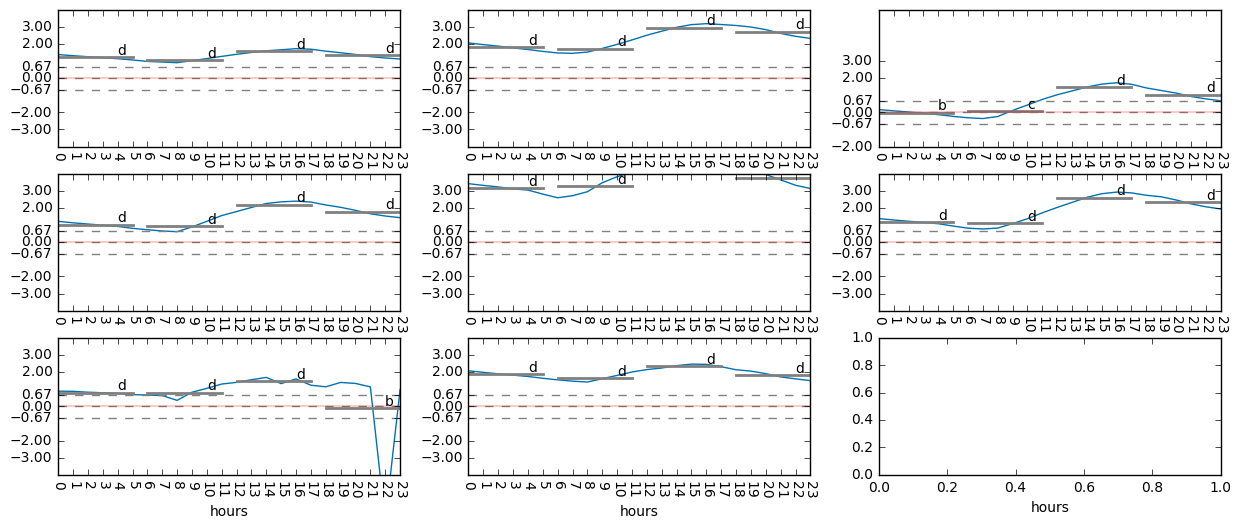

In [18]:
sax_model = sax
#discord_candidates = [3, 10, 18, 29]
nrows = int(np.ceil(len(discord_candidates)/3))
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15,6))
i, j = 0 , 0
x = range(24)

for n in discord_candidates:
    if j>2: 
        j=0
        i+=1
    y_to_sax = model.means_[n]
    y_to_sax = (y_to_sax - general_mean)/general_std
    words1 = sax_model.symbolize_signal(y_to_sax)
    paa_sequence = sax_model.signal_to_paa_vector(y_to_sax)
    df_profile = pd.DataFrame(y_to_sax)
    plot_sax_sequence(axes[i][j], words1, paa_sequence, df_profile, cutpoints2)
    axes[i][j].set_xticks(x)
    axes[i][j].set_xlim([0,23])
    axes[i][j].set_ylim([-4,4])
    if i==0 and j==2:
        axes[i][j].set_ylim([-2,6])
    axes[i][j].set_xticklabels(labels = x, rotation=-90)
    axes[-1][j].set_xlabel('hours')
    j +=1


[0, 1, 3, 5, 6, 7, 9, 10, 11, 13, 15, 16, 17, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32]


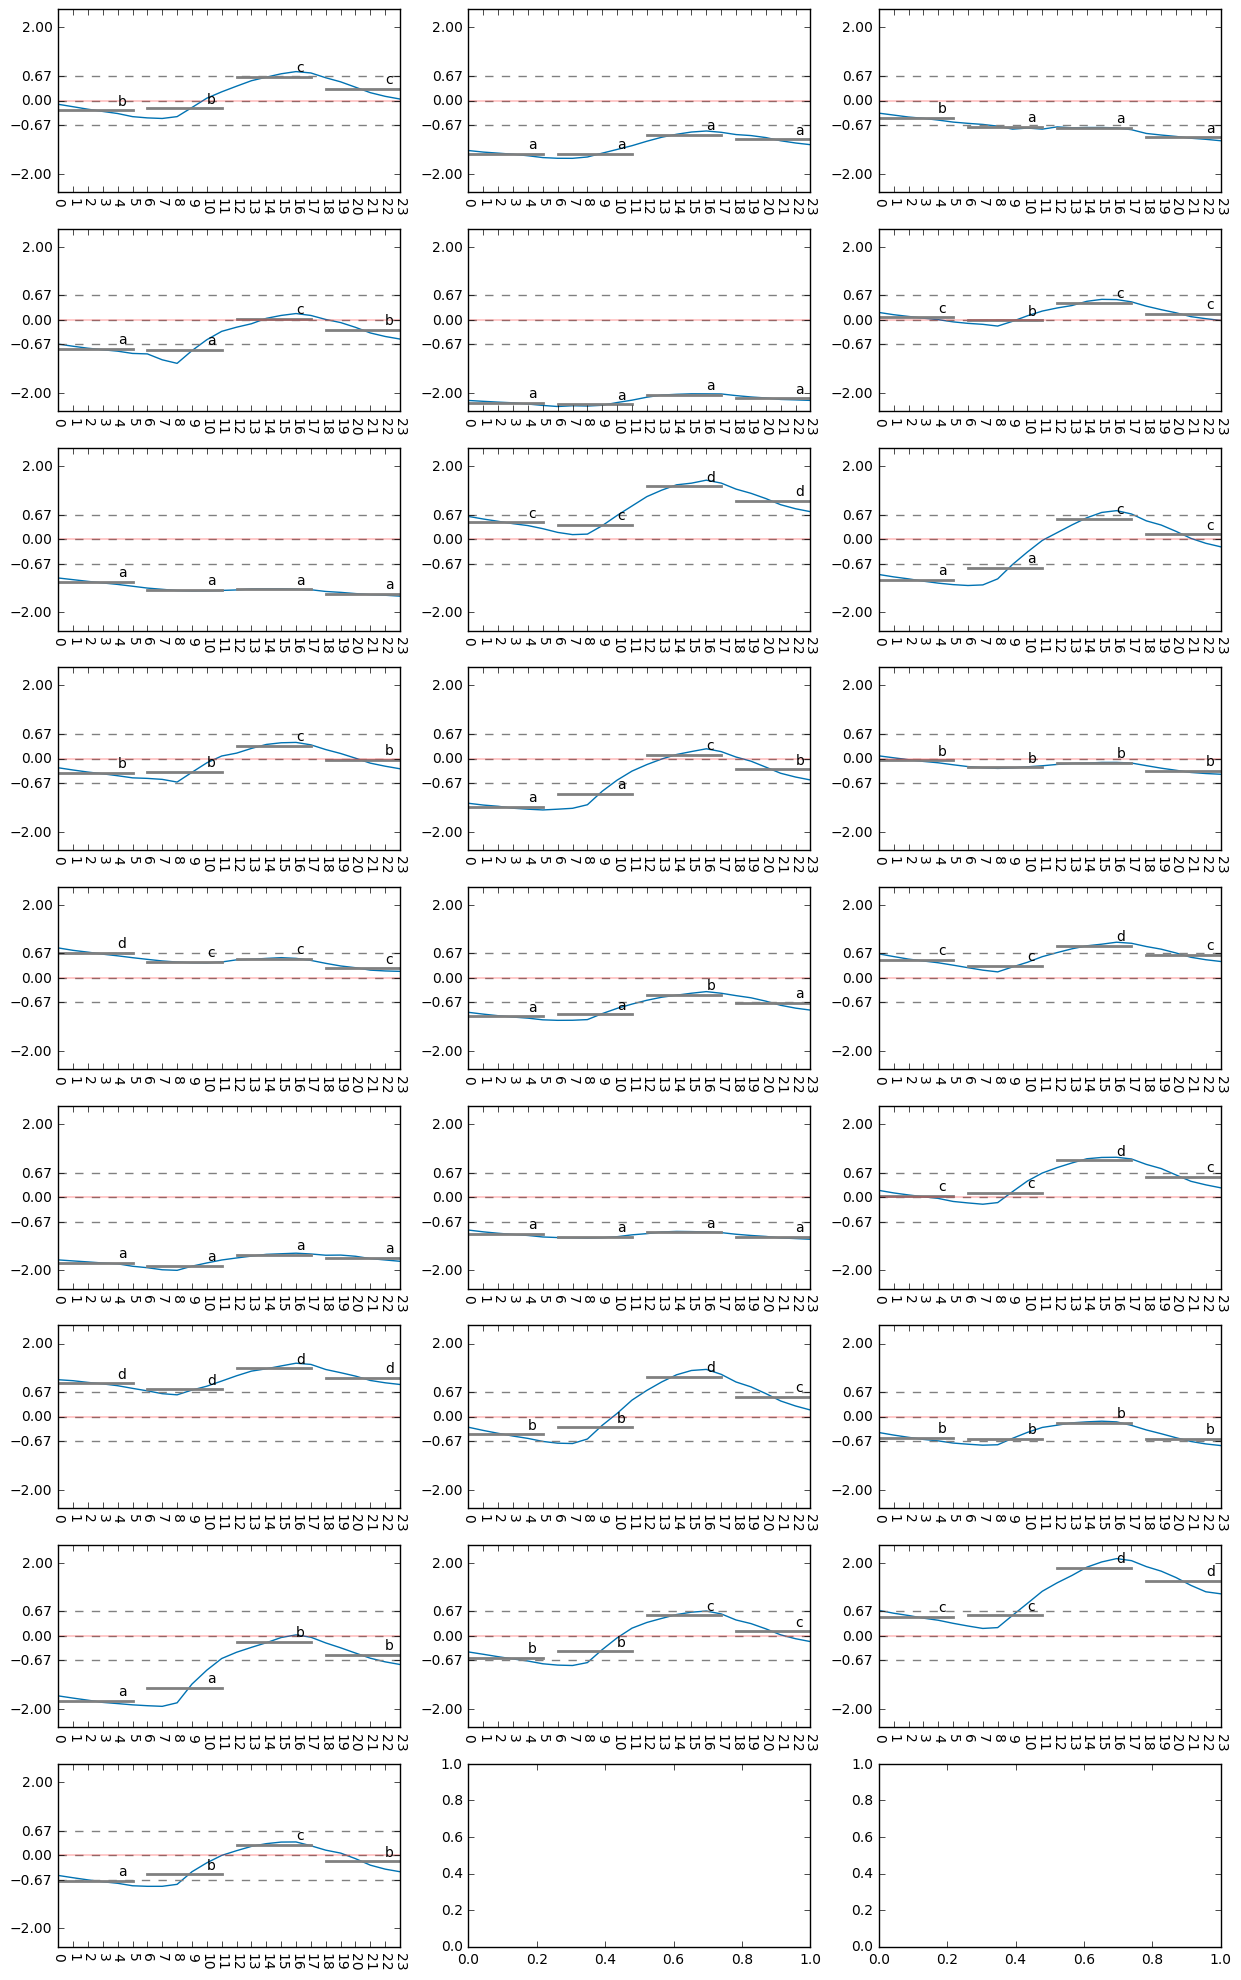

In [19]:
sax_model = sax

nrows = int(np.ceil(len(motif_candidates)/3))
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15,25))
i, j = 0 , 0
x = range(24)
print(motif_candidates)
for n in motif_candidates:
    if j>2: 
        j=0
        i+=1
    y_to_sax = model.means_[n]
    y_to_sax = (y_to_sax - general_mean)/general_std
    words1 = sax_model.symbolize_signal(y_to_sax)
    paa_sequence = sax_model.signal_to_paa_vector(y_to_sax)
    df_profile = pd.DataFrame(y_to_sax)
    plot_sax_sequence(axes[i][j], words1, paa_sequence, df_profile, cutpoints2)
    axes[i][j].set_xticks(x)
    axes[i][j].set_xlim([0,23])
    axes[i][j].set_ylim([-2.5,2.5])
    #if i==1 and j==0:
    #    axes[i][j].set_ylim([-2,6])
    axes[i][j].set_xticklabels(labels = x, rotation=-90)
    j +=1

In [49]:
# define model for SAX representation
sax_nbins_size = 6              # 4 is the final value
sax_alphabet = "abc"           # "LbaH" is the final alphabet
window = 24                     # 24 hours window, stride = window because we do not want overlapping windows
sax = pysax.SAXModel(stride=window, window=window,  nbins=sax_nbins_size, alphabet=sax_alphabet)

words = sax.symbolize_signal(df_x[tag].values)
df_sax = pd.DataFrame(index=timeline,data=words,columns=['sax_word'])

In [50]:
sax_model = sax
df_ = df_sax
sax_list = list()
hmm_list = list()
for n in discord_candidates:
    y_to_sax = model.means_[n]
    y_to_sax = (y_to_sax - general_mean)/general_std
    words = sax_model.symbolize_signal(y_to_sax)
    #print(words)
    sax_dates = df_[df_['sax_word'] == words[0]].index
    
    sax_dates = [x._date_repr for x in sax_dates]
    hmm_dates = dict_model['dates_discord'][n]
    
    sax_list +=sax_dates
    hmm_list +=hmm_dates
    #print(words)

#print(len(set(sax_list)))
#print(len(set(hmm_list)))
hmm_list = list(set(hmm_list))
sax_list = list(set(sax_list))
# sax cointains some candidates that are not in hmm 
difference_sax = [x for x in sax_list if not x in hmm_list]
# hmm cointains some candidates that are not in sax
difference_hmm = [x for x in hmm_list if not x in sax_list]
coincidence = [x for x in hmm_list if x in sax_list]
#print(len(difference_sax))
#print(len(difference_hmm))

total_candidates = list(set(sax_list + hmm_list))
print('Observe the difference between both approaches:')
print('Number of sax days:', len(sax_list))
print('Number of hmm days:',len(hmm_list))
print('Number of days where both have coincidence:', len(coincidence))
print('Total number of candidates:',len(total_candidates))




Observe the difference between both approaches:
Number of sax days: 225
Number of hmm days: 114
Number of days where both have coincidence: 102
Total number of candidates: 237


SAX is more sensible for this profiles: (is able to spot better than hmm)


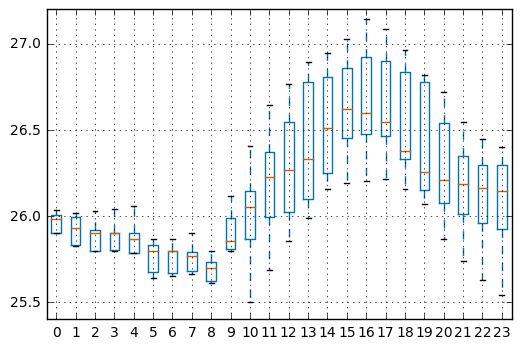

In [32]:
print('SAX is more sensible for this profiles: (is able to spot better than hmm)')
df = rs.get_tag_pivoted_values(collection_series, difference_sax, tag)
df = df.sort_values(by=[0,1,2,10,11,12, 21,22,23])
df.head(10).boxplot(showfliers=False)
plt.show()

GaHMM is more sensible for this profiles: (is able to spot better than SAX)


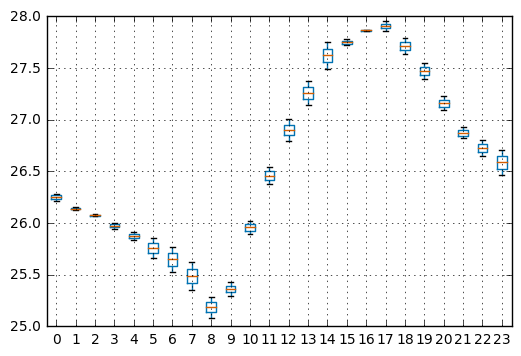

Index(['2012-10-22', '2012-07-27', '2013-09-02', '2014-04-23', '2012-10-18',
       '2012-08-15', '2014-04-24', '2014-10-09', '2014-04-26', '2013-08-29',
       '2013-10-22', '2013-06-04', '2013-06-12', '2015-05-11', '2012-09-07',
       '2014-09-25', '2014-08-06', '2012-08-29', '2015-04-28', '2014-07-24',
       '2013-07-12', '2014-10-15', '2013-08-26', '2015-06-02', '2012-06-28',
       '2013-09-04', '2015-04-15'],
      dtype='object')


In [33]:
print('GaHMM is more sensible for this profiles: (is able to spot better than SAX)')
df = rs.get_tag_pivoted_values(collection_series, difference_hmm, tag)
df = df.sort_values(by=[12,13,14])
df.tail(2).boxplot()
plt.show()
print(df.index)